In [1]:
# utilities
import pandas as pd
import jsonlines
import json
import pickle
import numpy as np
import ast
from csv import DictReader

# model training
#for binary classification
from sklearn import svm
#for hyperparams tuning
from sklearn.model_selection import RandomizedSearchCV
#for the confusion matrix
from sklearn import metrics

#visualization 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dev_df = pd.read_csv('emb_dev.csv',nrows=100)
test_df = pd.read_csv('emb_test.csv',nrows=100)
train_df = pd.read_csv('emb_train.csv',nrows=100)

In [3]:
''' Method to modify the dataset taking only the usefull fields 'output' and 'claim_embedding' and convert the output's values into binary values for the classification
  Input: dataframe to modify
  Output: modified dataframe
'''
def modify_df(df):  
    #delete the useless columns
    del df['id']
    del df['input']
    
    list_item=[]
    list_values=[]
    
    #extract the items from the output column
    series_output = pd.DataFrame(df['output'])
    for item in series_output['output']:
        #to convert the string of list into list of dict
        list_item=ast.literal_eval(item)
        # change values to represent labels as 0 ("REFUTES") and 1 ("SUPPORTS") and add them to a list
        for i in list_item:
            if (i['answer'] == 'REFUTES'):
                list_values.append(0)
            else:
                list_values.append(1)

    #create a new column of the df with the list of zeros and ones 
    df['labels'] = list_values
    #delete the output column
    del df['output']
    return df 

In [4]:
# obtain the dataset processed 
dev = modify_df(dev_df)
train = modify_df(train_df)

For training the classification model, firstly we split the datasets

In [5]:
x_train_emb = train['claim_embedding']
#convert string to list 
x_train = [n.strip('][').split(', ') for n in x_train_emb]

y_train = train.labels

In [6]:
x_dev_emb = dev['claim_embedding']
#convert string to list 
x_dev = [n.strip('][').split(', ') for n in x_dev_emb]

y_dev = dev.labels

In [7]:
test_set = test_df.claim_embedding
#convert string to list 
x_test = [n.strip('][').split(', ') for n in test_set]

# SVM
### Tuning on the dev set
Function for tuning the hyperparameters. It returns the best params to use for the SVM

In [8]:
''' Method for tuning the hyperparameters
  Input: splitted dev set into x and y for the fit of the RandomizedSearchCV
  Output: best params to use for the SVM
'''
def tuning(x_dev,y_dev):
    # define the parameter values that should be searched
    C_range= list(np.arange(1,5,0.5))
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    gamma = ['auto', 'scale']
    probability = [True,False] # different types of distances (manhattan, euclidean, minkowksi)
    decision_function_shape= ['ovo', 'ovr']
    random_state_range=list(range(2,42,10))
    
    # save the "parameter grid"
    param_grid = dict(C=C_range,kernel=kernel, gamma=gamma,\
                      decision_function_shape=decision_function_shape,\
                      random_state=random_state_range,probability=probability)
    
    print('Params grid: ',param_grid) #need this for the report

    #define the classification model chosen
    model = svm.SVC()
    rand = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=5, n_jobs=-1)
    rand.fit(x_dev, y_dev)
    rand.cv_results_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    #save the optimize parameters
    best_param = rand.best_params_
    #return the tuning params for the model
    return best_param 

In [9]:
params = tuning(x_dev,y_dev) #dict of best parameters for the classifier

Params grid:  {'C': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['auto', 'scale'], 'decision_function_shape': ['ovo', 'ovr'], 'random_state': [2, 12, 22, 32], 'probability': [True, False]}
Rand. Best Score:  0.8800000000000001


#### Now using the best parameter obtained by the tuning with the RandomizedSearchCV, we can train the train_set with the SVM

In [10]:
''' Method for training the model using the SVC() as binary classifier. After the training, the model is saved into a pickle file
  Input: dictionary of the tuned parameters, train set splitted in feature and target (x_train, y_train)
'''
def classifier(params, x_train, y_train):
    #train the model using the optimized params obtained in the tuning
    SVM = svm.SVC(C=params['C'],gamma=params['gamma'],decision_function_shape=params['decision_function_shape'],\
                 kernel=params['kernel'],probability=params['probability'],random_state=params['random_state'])
    
    #fit the model
    SVM.fit(x_train, y_train)
    
    # save the model to disk
    filename = 'SVM.sav'
    pickle.dump(SVM, open(filename, 'wb'))

In [11]:
classifier(params, x_train, y_train)

DO CLASS PREDICTION ON THE SAVED MODEL 

In [12]:
# load the trained model from disk
SVM = pickle.load(open('SVM.sav', 'rb'))

In [13]:
# make class predictions for the dev set, we need this to evaluate the model
y_pred_class = SVM.predict(x_dev)

EVALUATE THE MODEL

In [14]:
''' Function for the evaluation of the model. Using the metrics function from the library sklearn, here we compute the accuracy_score, the confusion_matrix and the precision and recall of the targets 'SUPPORTS', 'REFUTES'.
  Input: y_dev, predicted class
  Output: accuracy score,confusion matrix,precision score,recall score
'''
def evaluation(y_dev,y_pred_class):    
    # compute the accuracy 
    accuracy = metrics.accuracy_score(y_dev, y_pred_class)
    
    #build the confusion matrix and plot it
    confusion = metrics.confusion_matrix(y_dev, y_pred_class)
                #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # compute the precision and the recall on the label and print them
    target_names = ['SUPPORTS', 'REFUTES']
    print(metrics.classification_report(y_dev, y_pred_class, target_names=target_names))
    
    return accuracy,confusion

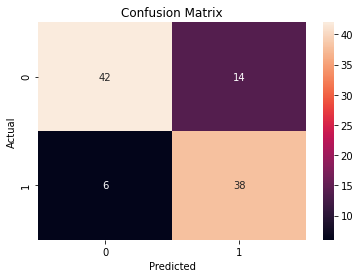

              precision    recall  f1-score   support

    SUPPORTS       0.88      0.75      0.81        56
     REFUTES       0.73      0.86      0.79        44

    accuracy                           0.80       100
   macro avg       0.80      0.81      0.80       100
weighted avg       0.81      0.80      0.80       100



In [15]:
results = evaluation(y_dev,y_pred_class)

In [16]:
print('Accuracy value: ',results[0])
conf_matrix = results[1]

Accuracy value:  0.8


In [17]:
conf_matrix

array([[42, 14],
       [ 6, 38]], dtype=int64)

In [18]:
print('F1 value: ', metrics.f1_score(y_dev, y_pred_class))

F1 value:  0.7916666666666666


**For the chosen classifier, get predictions for the official test set associated to the best hyperparameter configuration.**

In [19]:
#RIGIRARE SOLO QUESTO
test_df = pd.read_csv('emb_test.csv',nrows=100)

In [20]:
test_set = test_df.claim_embedding
#convert string to list 
x_test = [n.strip('][').split(', ') for n in test_set]

In [21]:
# load the trained model from disk
SVM = pickle.load(open('SVM.sav', 'rb'))
# get predictions for the official test set 
pred_test = SVM.predict(x_test)

In [23]:
pred_test

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [35]:
with open('emb_test.csv', 'r') as read_obj:
    # pass the file object to DictReader() to get the DictReader object
    dict_reader = DictReader(read_obj)
    # get a list of dictionaries from dict_reader
    json_test = list(dict_reader)

    #delete the useless fields    
for i in range(len(json_test)):
    del json_test[i]['claim_embedding'], json_test[i]['input']

In [36]:
for index in range(len(json_test)): 
    if pred_test[index]==1:
        json_test[index]['output']= [{'answer':"SUPPORT"}]
    else:
        json_test[index]['output']= [{'answer':"REFUTES"}]

IndexError: index 100 is out of bounds for axis 0 with size 100

In [28]:
json_test

[{'id': '161592', 'answer': {'label': 'REFUTES'}},
 {'id': '65795', 'answer': {'label': 'REFUTES'}},
 {'id': '34704', 'answer': {'label': 'REFUTES'}},
 {'id': '179775', 'answer': {'label': 'REFUTES'}},
 {'id': '82854', 'answer': {'label': 'REFUTES'}},
 {'id': '169240', 'answer': {'label': 'REFUTES'}},
 {'id': '164387', 'answer': {'label': 'REFUTES'}},
 {'id': '91295', 'answer': {'label': 'REFUTES'}},
 {'id': '84803', 'answer': {'label': 'REFUTES'}},
 {'id': '6549', 'answer': {'label': 'REFUTES'}},
 {'id': '32930', 'answer': {'label': 'REFUTES'}},
 {'id': '143761', 'answer': {'label': 'REFUTES'}},
 {'id': '47344', 'answer': {'label': 'REFUTES'}},
 {'id': '110338', 'answer': {'label': 'REFUTES'}},
 {'id': '216604', 'answer': {'label': 'REFUTES'}},
 {'id': '117692', 'answer': {'label': 'REFUTES'}},
 {'id': '159310', 'answer': {'label': 'REFUTES'}},
 {'id': '16412', 'answer': {'label': 'REFUTES'}},
 {'id': '24582', 'answer': {'label': 'REFUTES'}},
 {'id': '14845', 'answer': {'label': 'REFU

**Put the predictions in a file named “test_set_pred_1.jsonl”**

In [ ]:
# save the prediction into a file
with jsonlines.open('test_set_pred.jsonl', mode = 'w') as writer:
    writer.write(json_test)